In [37]:
import sys, os
# os.environ["THEANO_FLAGS"] = "device=cuda"  # use gpu
sys.path.append("../../../")
import gempy as gp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import logging
from importlib import reload
from copy import copy

Active grids: ['regular']
Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  2
Compilation Done!


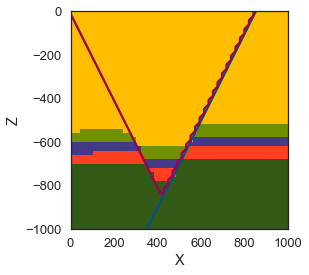

In [38]:
geo_model = gp.load_model(
    'Tutorial_ch1-9b_Fault_relations', 
    path= '../../data/gempy_models', 
    recompile=True
)
gp.compute_model(geo_model)
gp.plot.plot_section(geo_model, show_data=True)

In [ ]:
logging.basicConfig(level=logging.DEBUG, format='%(message)s')
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

# NUMPY TOPOLOGY

In [39]:
import topology_numpy as tpn

In [ ]:
# get the lb, fb from block matrix
lb, fb = tpn.lithblock_to_lb_fb(geo_model)
# generate unique labels block from combination of lb and fb's
labels = tpn.get_labels_block(lb, fb).reshape(50, 50, 50)
# shift the blocks to get the "topology block"
shift_blocks = tpn.get_topo_block(labels, n_shift=1)
# remove non-edge sums
shift_blocks[np.isin(shift_blocks, 2 * np.unique(labels))] = 0
# extract edges from the shift block
edges = tpn.get_edges(shift_blocks, labels, 1)
# calculate centroids of geobodies
centroids = tpn.get_centroids(labels)
# ----------------------------------------------
# --- theano end
# ----------------------------------------------
# create a LOT to go from sums to lith id's
node_to_layer_LOT = tpn.get_lith_lot(labels, 2, 5)

# Topology dimension implementation

In [122]:
reload(tpn)

<module 'topology_numpy' from 'C:\\Users\\r02as18\\git\\gempy\\notebooks\\experimental\\topology\\topology_numpy.py'>

In [124]:
%%timeit
edges, centroids = tpn.compute_topology(geo_model)

70.4 ms ± 2.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [81]:
lb, fb = tpn.lithblock_to_lb_fb(geo_model)
n_faults = 2
n_liths = 5
n_shift = 1
res = geo_model.grid.regular_grid.resolution

topology_labels = tpn.get_topology_labels(lb, fb, n_liths)
shift_xyz_block = tpn.topology_shift(topology_labels, res, n_shift=n_shift)
labels = tpn.bitstack_topology_labels(topology_labels).reshape(*res)
edges = tpn.get_edges(shift_xyz_block, labels, res, n_shift)
centroids = tpn.get_centroids(labels)

In [106]:
np.argwhere(np.array(list(np.binary_repr(e1).zfill(9))).astype(int) == 1)

array([[1],
       [5],
       [7]], dtype=int64)

In [91]:
for e1, e2 in edges:
    print(np.binary_repr(e1).zfill(9), np.binary_repr(e2).zfill(9))

010001010 000100101
000100101 010001010
000101010 000011001
010001010 000010101
000010101 000101010
001001010 000101001
000011010 000011001
100001010 001000101
001000101 100001010
100000101 010000101
010001010 001001010
010001001 001001001
001001010 000011001
000101010 000010101
000010101 001001010
000101010 000011010
100001010 001001001
000101001 000011001
100001010 010001001
100001010 100001001
000011010 000010101
000010101 000011010
001000101 000100101
001001010 000101010
000101001 001001001
001001001 000101001
001001010 000010101
000011001 000010101
010001010 000101001
000010101 000011001
100001010 100000101
100001010 010000101
100000101 100001010
010000101 100001010
010000101 001000101
100001010 010001010
010001001 100001001
100001001 010001001
000100101 000010101
010001010 001001001


In [35]:
import gempy.assets.topology as tp

In [36]:
%%timeit
G, c = tp.compute_topology(geo_model, filter_rogue=True, compute_areas=False)

356 ms ± 3.75 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


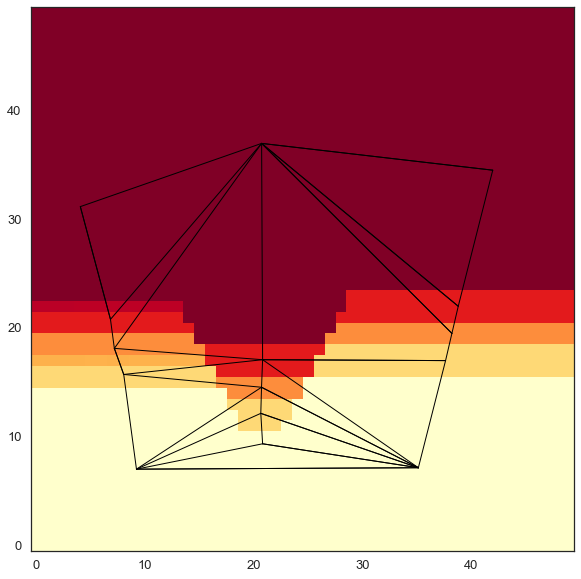

In [85]:
fig = plt.figure(figsize=(10,10))
plt.imshow(geo_model.solutions.block_matrix[-1].reshape(50,50, 50)[:, 24, :].T, origin="lower", cmap="YlOrRd_r")

for e1, e2 in edges:
    p1, p2 = centroids.get(e1), centroids.get(e2)
    x, y = (p1[0], p2[0]), (p1[2], p2[2])
    plt.plot(x, y, c="k", linewidth=1)
    
# for node in np.unique(labels):
#     p = centroids.get(node)
#     plt.scatter(p[0], p[2], c="k", s=500)
#     plt.text(p[0], p[2], str(node_to_layer_LOT[node]), c="w")

In [65]:
shift_xyz_block

array([[ 25,  25,  25, ..., 261, 261, 261],
       [ 25,  25,  25, ..., 261, 261, 261],
       [ 25,  25,  25, ..., 261, 261, 261]])

In [59]:
f_labels = tpn.get_fault_labels(n_faults)
# print(f_labels)

fault_labels_bin = tpn.get_fault_label_comb_bin(f_labels)
# print(bin_str_faults)

lith_labels_bin = tpn.get_lith_labels_bin(n_liths)
# print(bin_str_lith)

adj_matrix_labels = tpn.get_adj_matrix_labels(lith_labels_bin, fault_labels_bin)
adj_matrix_labels

adj_matrix = tpn.get_adj_matrix(edges, adj_matrix_labels, labels)

plt.imshow(adj_matrix)

ValueError: '000001010' is not in list

In [138]:
tri_i, tri_j = np.tril_indices(adj_matrix.shape[0])
topology_vector = adj_matrix[tri_i, tri_j]
topology_vector

array([ True,  True,  True, False, False, False,  True, False, False,
        True,  True, False, False, False,  True,  True,  True, False,
       False, False,  True, False, False, False, False, False, False,
       False,  True, False, False,  True, False, False, False,  True,
       False, False, False, False,  True, False, False, False,  True,
        True, False, False, False,  True,  True, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False,  True, False, False, False,  True, False, False, False,
       False, False, False, False, False,  True, False, False, False,
        True, False, False, False, False,  True, False, False, False,
        True,  True, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False,

In [174]:
topology_vector.shape

(210,)

In [143]:
import networkx as nx
G = nx.from_numpy_matrix(adj_matrix)

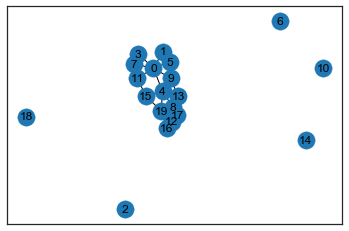

In [148]:
nx.draw_networkx(G)

In [146]:
for edge in G.edges:
    print(edge)

(0, 0)
(0, 1)
(0, 3)
(0, 4)
(0, 5)
(0, 7)
(0, 9)
(0, 11)
(1, 1)
(1, 5)
(3, 3)
(3, 7)
(4, 4)
(4, 8)
(4, 9)
(4, 13)
(4, 15)
(4, 19)
(5, 5)
(5, 9)
(7, 7)
(7, 11)
(8, 8)
(8, 12)
(8, 13)
(8, 17)
(8, 19)
(9, 9)
(9, 13)
(11, 11)
(11, 15)
(12, 12)
(12, 16)
(12, 17)
(12, 19)
(13, 13)
(13, 17)
(15, 15)
(15, 19)
(16, 16)
(16, 17)
(16, 19)
(17, 17)
(17, 19)
(19, 19)


# Other

# Speed comparison

In [628]:
logger.setLevel(logging.CRITICAL)

In [636]:
%%timeit
lb, fb = tpn.lithblock_to_lb_fb(geo_model)
labels = tpn.get_labels_block(lb, fb).reshape(50, 50, 50)
shift_blocks = tpn.get_topo_block(labels, n_shift=1)
shift_blocks[np.isin(shift_blocks, 2*np.unique(labels))] = 0
edges = tpn.get_edges(shift_blocks, labels, 1)
centroids = tpn.get_centroids(labels)
node_to_layer_LOT = tpn.get_lith_lot(labels, 2)

52.9 ms ± 1.83 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%timeit
G, c = tp.compute_topology(geo_model, filter_rogue=True, compute_areas=False)

In [631]:
print(f"Speed-up: {375  / 50.7:.02f}x" )

Speed-up: 7.40x


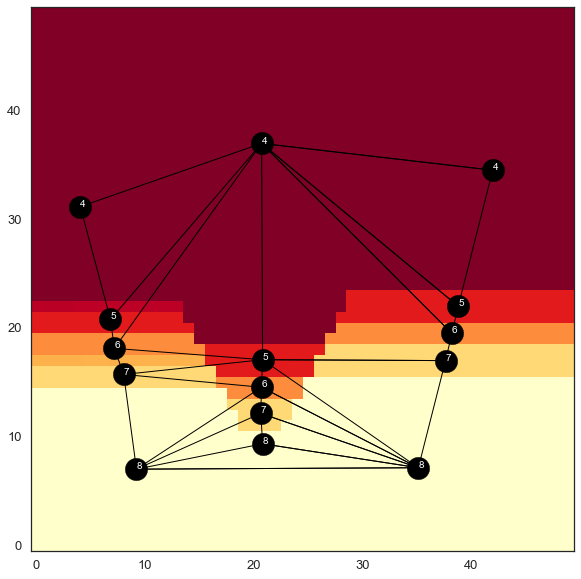

In [634]:
fig = plt.figure(figsize=(10,10))
plt.imshow(geo_model.solutions.block_matrix[-1].reshape(50,50, 50)[:, 24, :].T, origin="lower", cmap="YlOrRd_r")

for edge in edges:
    e1, e2 = edge
    p1 = centroids.get(e1)
    p2 = centroids.get(e2)
    x = (p1[0], p2[0])
    y = (p1[2], p2[2])
    plt.plot(x, y, c="k", linewidth=1)
    
for node in ulabels:
    p = centroids.get(node)
    plt.scatter(p[0], p[2], c="k", s=500)
    plt.text(p[0], p[2], str(node_to_layer_LOT[node]), c="w")

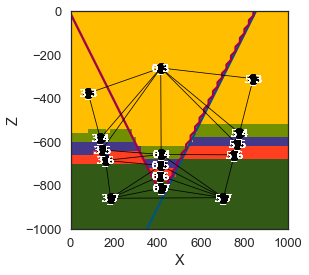

In [635]:
from gempy.assets import topology as tp
G, c = tp.compute_topology(geo_model, filter_rogue=True)
gp.plot.plot_section(geo_model, 24)
gp.plot.plot_topology(geo_model, G, c)